# X-LoVoCCS Luminosity-Temperature Relations

In this notebook we create luminosity-temperature scaling relations from our analyses of the X-LoVoCCS galaxy clusters. The 'global' X-ray analyses of LoVoCCS clusters were performed with two different modes of spectral fitting, one with the metallicity frozen at 0.3$Z_{\odot}$, and one with metallicity free to vary. 

We construct scaling relations from temperatures and luminosities measured within XGA-LTR derived $R_{500}$ apertures, as well as in 'core-excised' annular regions from [0.15-1]$R_{500}$. Luminosities are measured in 0.5-2.0keV and bolometric (0.01-100.0keV) bands, and are corrected for hydrogen column absorption. As such, 8 different variations on a LT relation are created in this notebook:
* $L^{52}_{\rm{X,500}}$-$T_{\rm{X,500}}$ - metallicity fixed
* $L^{52}_{\rm{X,500}}$-$T_{\rm{X,500}}$ - metallicity free
* $L^{52}_{\rm{X,500ce}}$-$T_{\rm{X,500ce}}$ - metallicity fixed
* $L^{52}_{\rm{X,500ce}}$-$T_{\rm{X,500ce}}$ - metallicity free
* $L^{bol}_{\rm{X,500}}$-$T_{\rm{X,500}}$ - metallicity fixed
* $L^{bol}_{\rm{X,500}}$-$T_{\rm{X,500}}$ - metallicity free
* $L^{bol}_{\rm{X,500ce}}$-$T_{\rm{X,500ce}}$ - metallicity fixed
* $L^{bol}_{\rm{X,500ce}}$-$T_{\rm{X,500ce}}$ - metallicity free

All scaling relations objects generated in this part of the analysis are saved and can be used to easily access these results. <font color='red'><b>They are currently saved as Pickles, which are only readable back into a Python object, and are very sensitive to changes in XGA version - we will create a better storage solution.</b></font> 

## Import Statements

In [1]:
import xga
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
from xga.relations.fit import scaling_relation_lira, scaling_relation_odr
from xga.relations.clusters.LT import xcs_sdss_r500_52, xcs_sdss_r500ce_52
from xga.models.misc import power_law
from xga import DEFAULT_COSMO

from astropy.units import Quantity
import pandas as pd
import numpy as np
import os

%matplotlib inline

## Creating Storage Directories

We ensure that the storage directory within which we will store the luminosity-temperature relations generated in this notebook exists - as well as the one where we store the figure we make for the scaling relations:

In [2]:
if not os.path.exists('../../outputs/scaling_relations/LT/'):
    os.makedirs('../../outputs/scaling_relations/LT/')
stor_pth = '../../outputs/scaling_relations/LT/'

if not os.path.exists('../../outputs/figures/scaling_relations/LT'):
    os.makedirs('../../outputs/figures/scaling_relations/LT/')
fig_pth = '../../outputs/figures/scaling_relations/LT/'

## Loading Results

We read in the tables containing results from the XGA-LTR pipeline run on the LoVoCCS galaxy clusters. These particular results were measured with metallicity frozen at $0.3Z_{\odot}$. Both tables contain the same galaxy clusters:

In [3]:
res500 = pd.read_csv('../../outputs/results/ltr_r500_pipeline_results.csv')
res500.head(5)

,name,ra,dec,redshift,nH,r500,r500+-,Tx500,Tx500-,Tx500+,...,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+,Lx500ce_0.1-2.4,Lx500ce_0.1-2.4-,Lx500ce_0.1-2.4+
0,LoVoCCS-1,227.734300,5.745471,0.0766,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LoVoCCS-2,44.740000,13.580000,0.0739,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LoVoCCS-4A,10.458750,-9.301944,0.0555,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LoVoCCS-4B,10.451487,-9.460007,0.0555,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LoVoCCS-5,303.157313,-56.845978,0.0556,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


These results were measured with metallicity free to vary in the spatial fits:

In [4]:
res500_metfree = pd.read_csv('../../outputs/results/ltr_r500_metfree_pipeline_results.csv')
res500_metfree.head(5)

,name,ra,dec,redshift,nH,r500,r500+-,Tx500,Tx500-,Tx500+,...,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+,Lx500ce_0.1-2.4,Lx500ce_0.1-2.4-,Lx500ce_0.1-2.4+,Zmet500ce,Zmet500ce-,Zmet500ce+
0,LoVoCCS-1,227.734300,5.745471,0.0766,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LoVoCCS-2,44.740000,13.580000,0.0739,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LoVoCCS-4A,10.458750,-9.301944,0.0555,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LoVoCCS-4B,10.451487,-9.460007,0.0555,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LoVoCCS-5,303.157313,-56.845978,0.0556,0.0427,1140.071096,18.439558,5.500868,0.110784,0.108399,...,1.285042e+43,2.624747e+44,3.936055e+43,2.546871e+43,1.260559e+44,1.770549e+43,1.775003e+43,0.198973,0.035115,0.035779


## Setting up for scaling relation fits

There are several variables and quantities we wish to set up before creating our scaling relations - first of all we define normalisations for the x (temperature) and y (luminosity) data that will be used in our fits.

<font color='red'>We currently use normalisations that were not chosen for any particular reason other than intuition, but they may be replaced by values based on the mean or median temperatures and luminosities, as we have done in past work.</font> 

In [5]:
tx_norm = Quantity(4, 'keV')

lx52_norm = Quantity(1e+44, 'erg/s')
lxbol_norm = Quantity(5e+44, 'erg/s')

We also read out the names and redshifts of the clusters from our table - as both resr500 and resr500_metfree contain the same clusters this should be valid for fits made using both sets of results. The names of the clusters can be passed to the scaling relations so that particular data points can be more easily investigated, and the redshifts are required to calculate E(z):

In [6]:
names = res500['name'].values
zs = res500['redshift'].values

We make use of the default cosmology defined in XGA, which is a concordance $\Lambda$CDM model:

In [7]:
DEFAULT_COSMO

LambdaCDM(name=None, H0=<Quantity 70. km / (Mpc s)>, Om0=0.3, Ode0=0.7, Tcmb0=<Quantity 0. K>, Neff=3.04, m_nu=None, Ob0=None)

We use the cosmology to calculate $E(z)^{-1}$, which will be multiplied with our luminosities before the scaling relations are plotted and fit:

In [8]:
inv_e = DEFAULT_COSMO.inv_efunc(zs)
inv_e

array([0.96477483, 0.96603877, 0.97461373, 0.97461373, 0.97456732,
       0.95471062, 0.97303449, 0.96106887, 0.9752169 , 0.98219513,
       0.96543038, 0.96683387, 0.96073995, 0.96106887, 0.97808842,
       0.95876463, 0.95659773, 0.95471062, 0.97298801, 0.96477483,
       0.94988715, 0.97535604, 0.96102189, 0.95541859, 0.95277369,
       0.96073995, 0.96073995, 0.96505583, 0.94580842, 0.95819969,
       0.95819969, 0.95819969, 0.97841208, 0.97739448, 0.94452579,
       0.95607903, 0.95862342, 0.95843511, 0.95843511, 0.95036073,
       0.94519098, 0.97910527, 0.95645628, 0.95645628, 0.97831962,
       0.95069216, 0.94856034, 0.95984673, 0.96069295, 0.94979242,
       0.94865515, 0.96238368, 0.97688527, 0.97688527, 0.95551296,
       0.96482167, 0.97466014, 0.94903433, 0.97140625, 0.97512413,
       0.95772873, 0.965524  ])

## Fitting with LIRA

We make use of the [LIRA fitting package](https://rdrr.io/cran/lira/) to generate our scaling relations. This is a fitting package for scaling relations that is implemented in R, so we  utilise an XGA LIRA interface, which also stores outputs in ScalingRelation product objects, which have some very useful features.

<font color='red'><b>Many of the figures currently have manual y-limits applied, I don't yet know why this is necessary - need to check the data and models</b></font> 

### $L^{52}_{\rm{X,500}}$-$T_{\rm{X,500}}$

We start by generating scaling relations between temperature and 0.5-2.0keV unabsorbed luminosity, within an XGA-LTR derived $R_{500}$, from both datasets:

#### Fixed Abundance

In [9]:
lx = Quantity(res500[['Lx500_0.5-2.0', 'Lx500_0.5-2.0-', 'Lx500_0.5-2.0+']].values, 'erg/s')*inv_e[..., None]
tx = Quantity(res500[['Tx500', 'Tx500-', 'Tx500+']].values, 'keV')

lx52_tx_r500_metfix = scaling_relation_lira(lx[:, 0], lx[:, 1:], tx[:, 0], tx[:, 1:], lx52_norm, tx_norm, 
                                            y_name=r'$E(z)^{-1}L^{52}_{\rm{X,500}}$', x_name=r'$T_{\rm{X,500}}$', 
                                            dim_hubb_ind=-1, point_names=names, third_dim_info=zs, 
                                            third_dim_name='Redshift', y_en_bounds=Quantity([0.5, 2.0], 'keV'))
lx52_tx_r500_metfix.author = "Turner et al."
lx52_tx_r500_metfix.model_colour = "tab:cyan"
lx52_tx_r500_metfix.name = r"X-LoVoCCS $R_{500}$ Met-Fixed"
lx52_tx_r500_metfix.save(stor_pth + 'lx52_tx_r500_metfix.xgarel')

/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:414: UserWarning: 16 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,
R[write to console]: module mix loaded



  |**************************************************| 100%


/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:450: UserWarning: 16 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


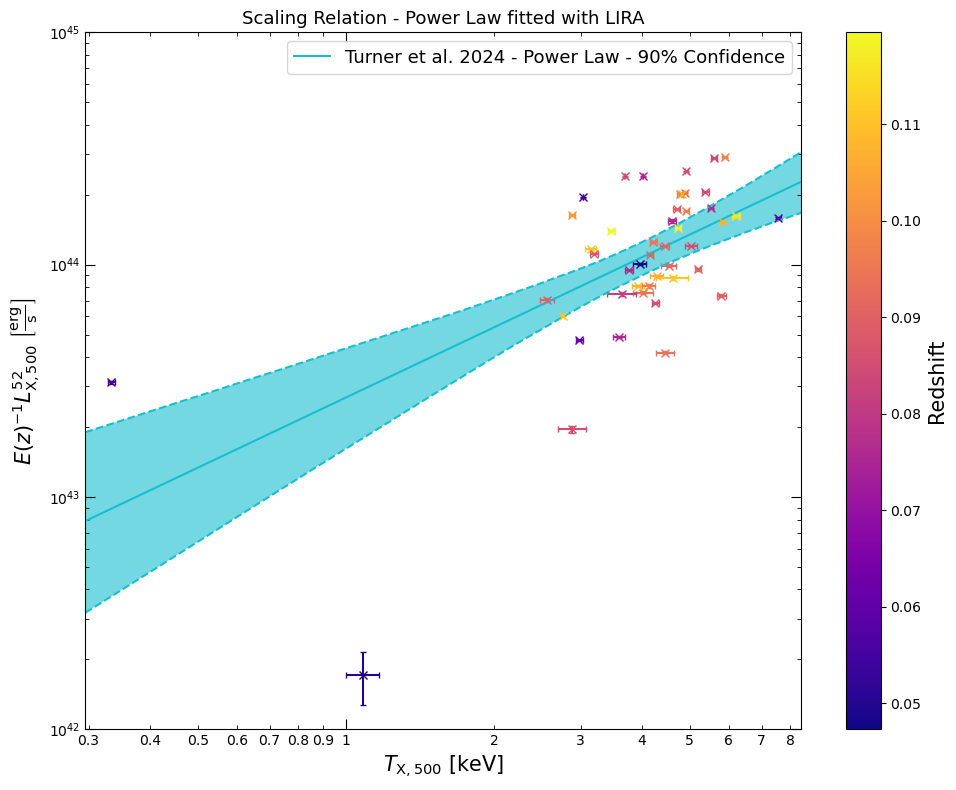

In [10]:
lx52_tx_r500_metfix.view(save_path=fig_pth+"lx52_tx_r500_metfix.pdf", y_lims=Quantity([1e+42, 1e+45], 'erg/s'))

#### Free Abundance

In [11]:
lx = Quantity(res500_metfree[['Lx500_0.5-2.0', 'Lx500_0.5-2.0-', 'Lx500_0.5-2.0+']].values, 
              'erg/s')*inv_e[..., None]
tx = Quantity(res500_metfree[['Tx500', 'Tx500-', 'Tx500+']].values, 'keV')

lx52_tx_r500_metfree = scaling_relation_lira(lx[:, 0], lx[:, 1:], tx[:, 0], tx[:, 1:], lx52_norm, tx_norm, 
                                             y_name=r'$E(z)^{-1}L^{52}_{\rm{X,500}}$', x_name=r'$T_{\rm{X,500}}$', 
                                             dim_hubb_ind=-1, point_names=names, third_dim_info=zs, 
                                             third_dim_name='Redshift', y_en_bounds=Quantity([0.5, 2.0], 'keV'))

lx52_tx_r500_metfree.author = "Turner et al."
lx52_tx_r500_metfree.model_colour = "firebrick"
lx52_tx_r500_metfree.name = r"X-LoVoCCS $R_{500}$ Met-Free"
lx52_tx_r500_metfree.save(stor_pth + 'lx52_tx_r500_metfree.xgarel')

/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:414: UserWarning: 16 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:450: UserWarning: 16 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


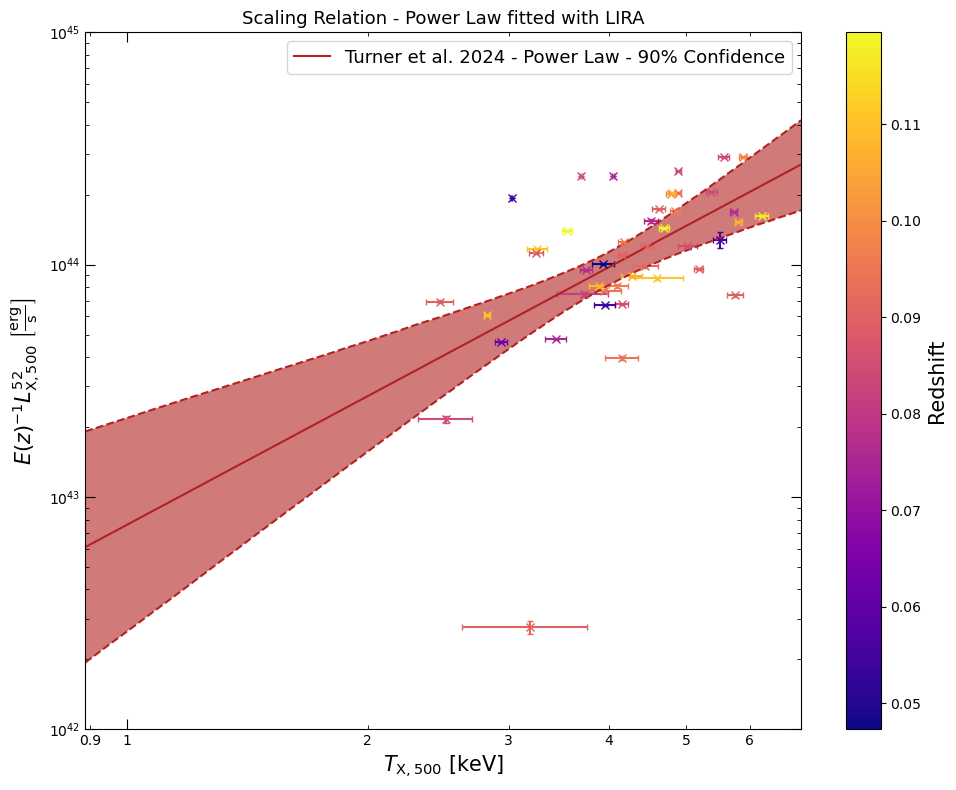

In [12]:
lx52_tx_r500_metfree.view(save_path=fig_pth+"lx52_tx_r500_metfree.pdf", y_lims=Quantity([1e+42, 1e+45], 'erg/s'))

### $L^{52}_{\rm{X,500ce}}$-$T_{\rm{X,500ce}}$

Now we create the relations between temperature and 0.5-2.0keV unabsorbed luminosity measured within a core-excised annular region:

#### Fixed Abundance

In [13]:
lx = Quantity(res500[['Lx500ce_0.5-2.0', 'Lx500ce_0.5-2.0-', 'Lx500ce_0.5-2.0+']].values, 'erg/s')*inv_e[..., None]
tx = Quantity(res500[['Tx500ce', 'Tx500ce-', 'Tx500ce+']].values, 'keV')

lx52_tx_r500ce_metfix = scaling_relation_lira(lx[:, 0], lx[:, 1:], tx[:, 0], tx[:, 1:], lx52_norm, tx_norm, 
                                              y_name=r'$E(z)^{-1}L^{52}_{\rm{X,500ce}}$', 
                                              x_name=r'$T_{\rm{X,500ce}}$', 
                                              dim_hubb_ind=-1, point_names=names, third_dim_info=zs, 
                                              third_dim_name='Redshift', y_en_bounds=Quantity([0.5, 2.0], 'keV'))
lx52_tx_r500ce_metfix.author = "Turner et al."
lx52_tx_r500ce_metfix.model_colour = "seagreen"
lx52_tx_r500ce_metfix.name = r"X-LoVoCCS $R_{500ce}$ Met-Fixed"
lx52_tx_r500ce_metfix.save(stor_pth + 'lx52_tx_r500ce_metfix.xgarel')

/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:414: UserWarning: 17 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:450: UserWarning: 17 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


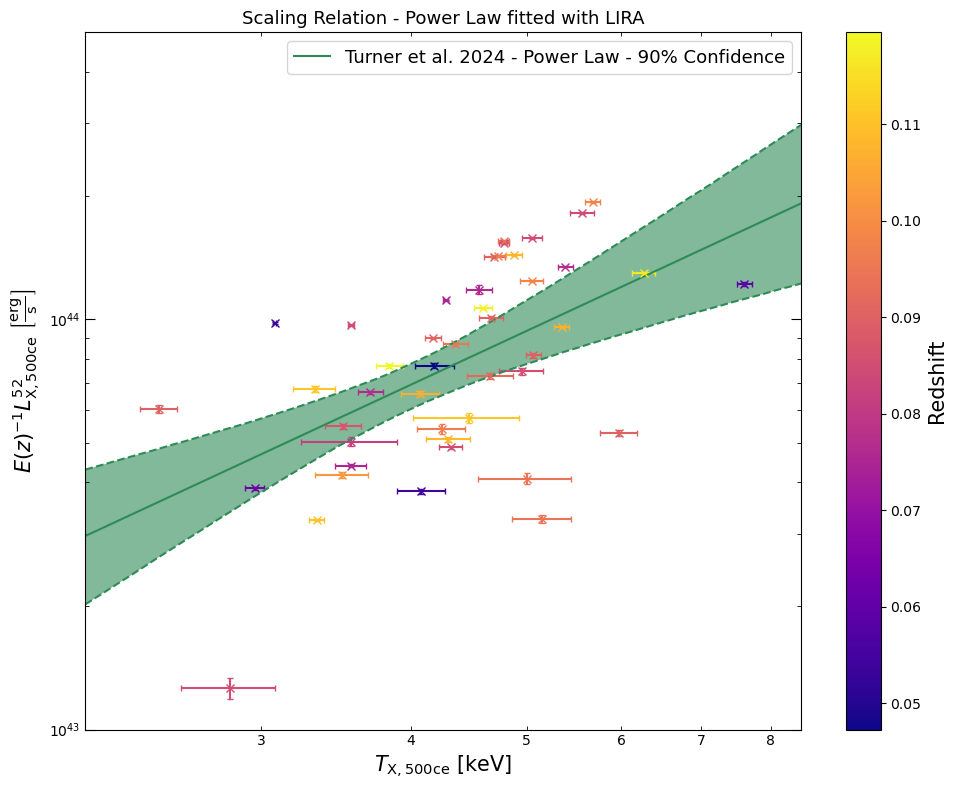

In [14]:
lx52_tx_r500ce_metfix.view(label_points=False, save_path=fig_pth+"lx52_tx_r500ce_metfix.pdf", y_lims=Quantity([1e+43, 5e+44], 'erg/s'))

#### Free Abundance

In [15]:
lx = Quantity(res500_metfree[['Lx500ce_0.5-2.0', 'Lx500ce_0.5-2.0-', 'Lx500ce_0.5-2.0+']].values, 
              'erg/s')*inv_e[..., None]
tx = Quantity(res500_metfree[['Tx500ce', 'Tx500ce-', 'Tx500ce+']].values, 'keV')

lx52_tx_r500ce_metfree = scaling_relation_lira(lx[:, 0], lx[:, 1:], tx[:, 0], tx[:, 1:], lx52_norm, tx_norm, 
                                               y_name=r'$E(z)^{-1}L^{52}_{\rm{X,500ce}}$', 
                                               x_name=r'$T_{\rm{X,500ce}}$', 
                                               dim_hubb_ind=-1, point_names=names, third_dim_info=zs, 
                                               third_dim_name='Redshift', y_en_bounds=Quantity([0.5, 2.0], 'keV'))
lx52_tx_r500ce_metfree.author = "Turner et al."
lx52_tx_r500ce_metfree.model_colour = "indigo"
lx52_tx_r500ce_metfree.name = r"X-LoVoCCS $R_{500ce}$ Met-Free"
lx52_tx_r500ce_metfree.save(stor_pth + 'lx52_tx_r500ce_metfree.xgarel')

/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:414: UserWarning: 17 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:450: UserWarning: 17 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


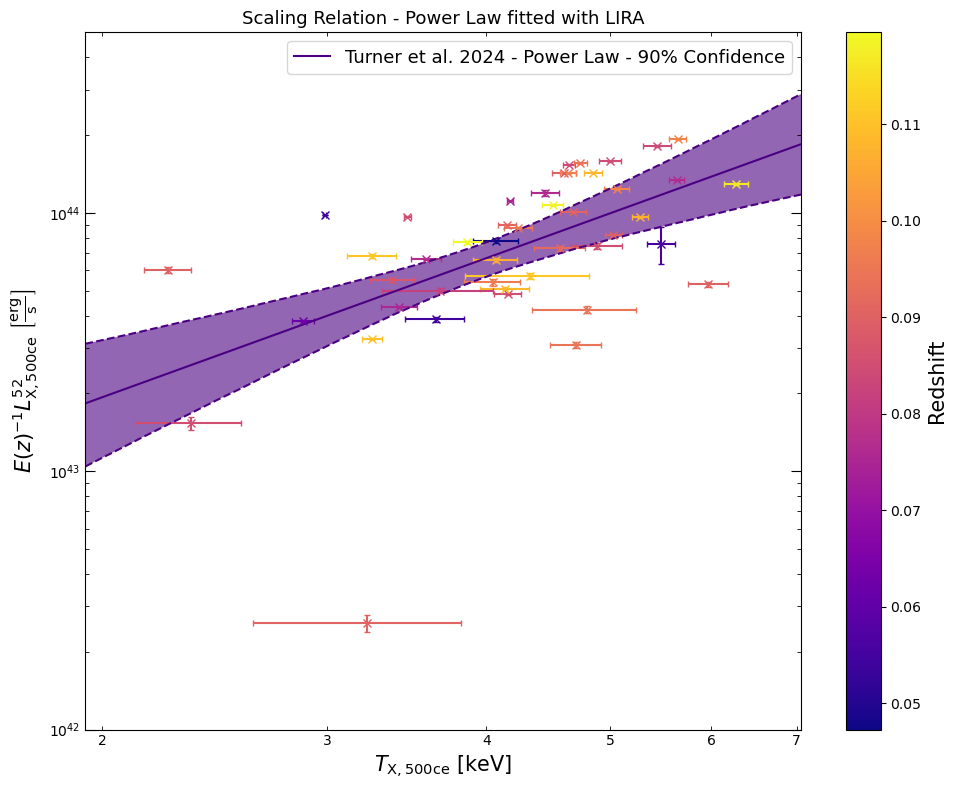

In [16]:
lx52_tx_r500ce_metfree.view(save_path=fig_pth+"lx52_tx_r500ce_metfree.pdf", y_lims=Quantity([1e+42, 5e+44], 'erg/s'))

### $L^{bol}_{\rm{X,500}}$-$T_{\rm{X,500}}$

Now we generate scaling relations between temperature and bolometric (0.01-100keV) unabsorbed luminosity, within $R_{500}$, from both datasets:

#### Fixed Abundance

In [17]:
lx = Quantity(res500[['Lx500_0.01-100.0', 'Lx500_0.01-100.0-', 'Lx500_0.01-100.0+']].values, 
              'erg/s')*inv_e[..., None]
tx = Quantity(res500[['Tx500', 'Tx500-', 'Tx500+']].values, 'keV')

lxbol_tx_r500_metfix = scaling_relation_lira(lx[:, 0], lx[:, 1:], tx[:, 0], tx[:, 1:], lxbol_norm, tx_norm, 
                                            y_name=r'$E(z)^{-1}L^{bol}_{\rm{X,500}}$', x_name=r'$T_{\rm{X,500}}$', 
                                            dim_hubb_ind=-1, point_names=names, third_dim_info=zs, 
                                            third_dim_name='Redshift', y_en_bounds=Quantity([0.01, 100.0], 'keV'))
lxbol_tx_r500_metfix.author = "Turner et al."
lxbol_tx_r500_metfix.model_colour = "tab:cyan"
lxbol_tx_r500_metfix.name = r"X-LoVoCCS $R_{500}$ Met-Fixed"
lxbol_tx_r500_metfix.save(stor_pth + 'lxbol_tx_r500_metfix.xgarel')

/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:414: UserWarning: 16 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:450: UserWarning: 16 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


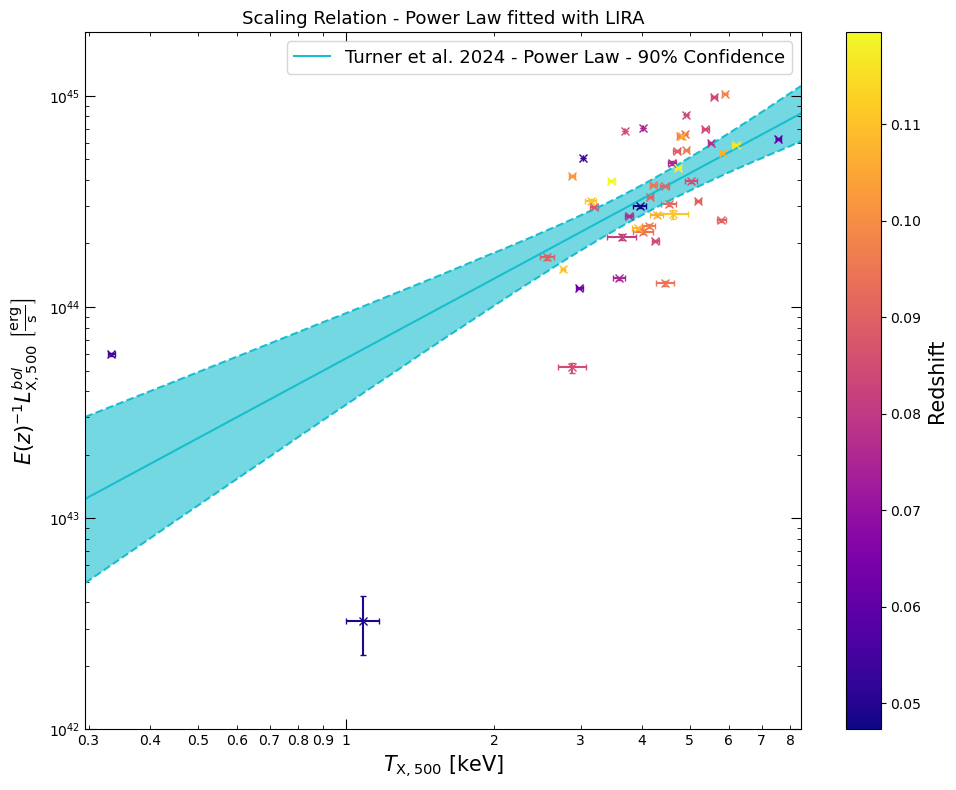

In [18]:
lxbol_tx_r500_metfix.view(save_path=fig_pth+"lxbol_tx_r500_metfix.pdf", y_lims=Quantity([1e+42, 2e+45], 'erg/s'))

#### Free Abundance

In [19]:
lx = Quantity(res500_metfree[['Lx500_0.01-100.0', 'Lx500_0.01-100.0-', 'Lx500_0.01-100.0+']].values, 
              'erg/s')*inv_e[..., None]
tx = Quantity(res500_metfree[['Tx500', 'Tx500-', 'Tx500+']].values, 'keV')

lxbol_tx_r500_metfree = scaling_relation_lira(lx[:, 0], lx[:, 1:], tx[:, 0], tx[:, 1:], lxbol_norm, tx_norm, 
                                              y_name=r'$E(z)^{-1}L^{bol}_{\rm{X,500}}$', 
                                              x_name=r'$T_{\rm{X,500}}$', dim_hubb_ind=-1, point_names=names, 
                                              third_dim_info=zs, third_dim_name='Redshift', 
                                              y_en_bounds=Quantity([0.01, 100.0], 'keV'))
lxbol_tx_r500_metfree.author = "Turner et al."
lxbol_tx_r500_metfree.model_colour = "firebrick"
lxbol_tx_r500_metfree.name = r"X-LoVoCCS $R_{500}$ Met-Free"
lxbol_tx_r500_metfree.save(stor_pth + 'lxbol_tx_r500_metfree.xgarel')

/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:414: UserWarning: 16 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:450: UserWarning: 16 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


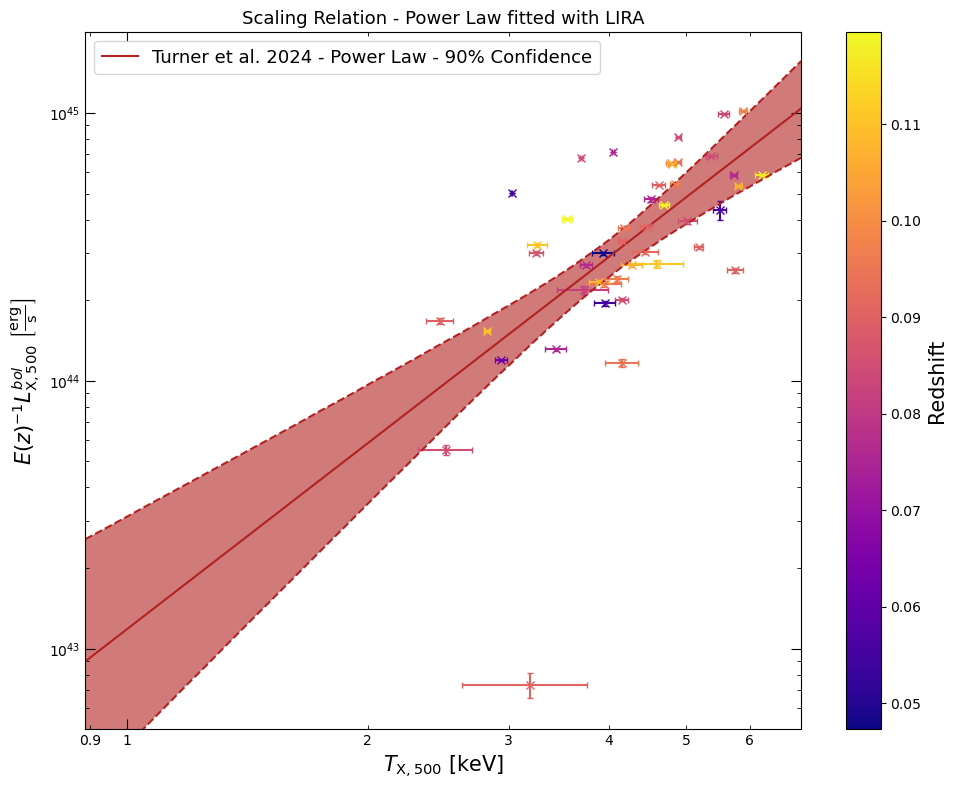

In [20]:
lxbol_tx_r500_metfree.view(save_path=fig_pth+"lxbol_tx_r500_metfree.pdf", y_lims=Quantity([5e+42, 2e+45], 'erg/s'))

### $L^{bol}_{\rm{X,500ce}}$-$T_{\rm{X,500ce}}$

Finally, we generate scaling relations between temperature and bolometric (0.01-100keV) unabsorbed luminosity, within core-excised $R_{500}$:

#### Fixed Abundance

In [21]:
lx = Quantity(res500[['Lx500ce_0.01-100.0', 'Lx500ce_0.01-100.0-', 'Lx500ce_0.01-100.0+']].values, 
              'erg/s')*inv_e[..., None]
tx = Quantity(res500[['Tx500ce', 'Tx500ce-', 'Tx500ce+']].values, 'keV')

lxbol_tx_r500ce_metfix = scaling_relation_lira(lx[:, 0], lx[:, 1:], tx[:, 0], tx[:, 1:], lxbol_norm, tx_norm, 
                                              y_name=r'$E(z)^{-1}L^{bol}_{\rm{X,500ce}}$', 
                                              x_name=r'$T_{\rm{X,500ce}}$', 
                                              dim_hubb_ind=-1, point_names=names, third_dim_info=zs, 
                                              third_dim_name='Redshift', 
                                               y_en_bounds=Quantity([0.01, 100.0], 'keV'))
lxbol_tx_r500ce_metfix.author = "Turner et al."
lxbol_tx_r500ce_metfix.model_colour = "seagreen"
lxbol_tx_r500ce_metfix.name = r"X-LoVoCCS $R_{500ce}$ Met-Fixed"
lxbol_tx_r500ce_metfix.save(stor_pth + 'lxbol_tx_r500ce_metfix.xgarel')

/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:414: UserWarning: 17 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:450: UserWarning: 17 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


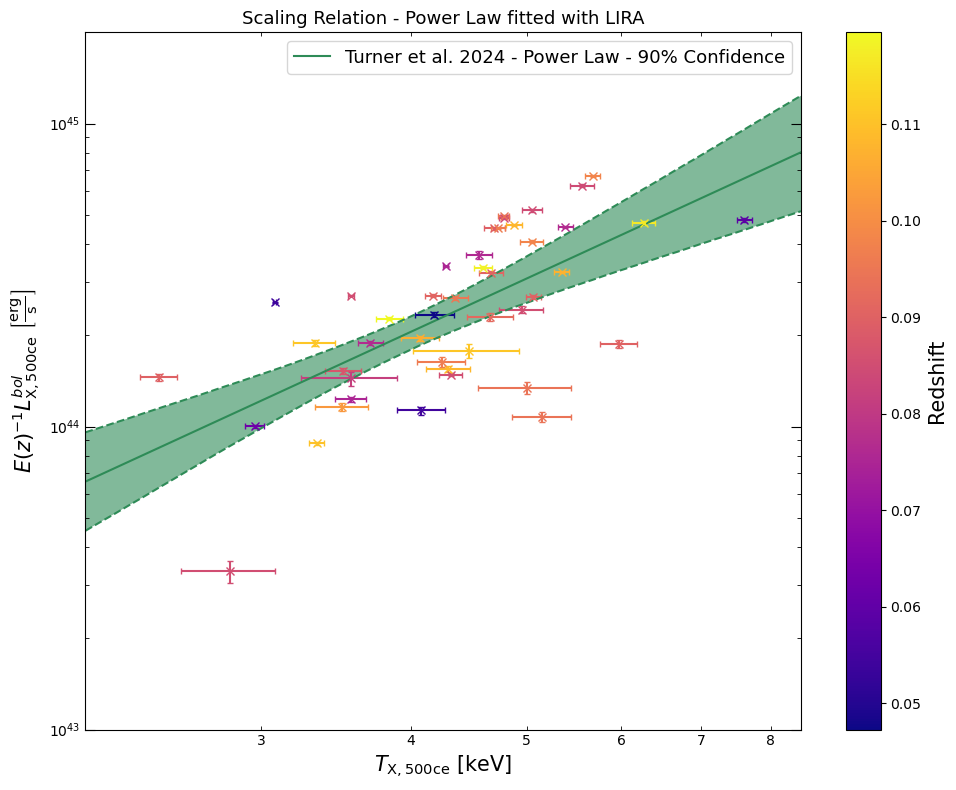

In [22]:
lxbol_tx_r500ce_metfix.view(save_path=fig_pth+"lxbol_tx_r500ce_metfix.pdf", y_lims=Quantity([1e+43, 2e+45], 'erg/s'))

#### Free Abundance

In [23]:
lx = Quantity(res500_metfree[['Lx500ce_0.01-100.0', 'Lx500ce_0.01-100.0-', 'Lx500ce_0.01-100.0+']].values, 
              'erg/s')*inv_e[..., None]
tx = Quantity(res500_metfree[['Tx500ce', 'Tx500ce-', 'Tx500ce+']].values, 'keV')

lxbol_tx_r500ce_metfree = scaling_relation_lira(lx[:, 0], lx[:, 1:], tx[:, 0], tx[:, 1:], lxbol_norm, tx_norm, 
                                                y_name=r'$E(z)^{-1}L^{bol}_{\rm{X,500ce}}$', 
                                                x_name=r'$T_{\rm{X,500ce}}$', 
                                                dim_hubb_ind=-1, point_names=names, third_dim_info=zs, 
                                                third_dim_name='Redshift', 
                                                y_en_bounds=Quantity([0.01, 100.0], 'keV'))
lxbol_tx_r500ce_metfree.author = "Turner et al."
lxbol_tx_r500ce_metfree.model_colour = "indigo"
lxbol_tx_r500ce_metfree.name = r"X-LoVoCCS $R_{500ce}$ Met-Free"
lxbol_tx_r500ce_metfree.save(stor_pth + 'lxbol_tx_r500ce_metfree.xgarel')

/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:414: UserWarning: 17 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/relations/fit.py:450: UserWarning: 17 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


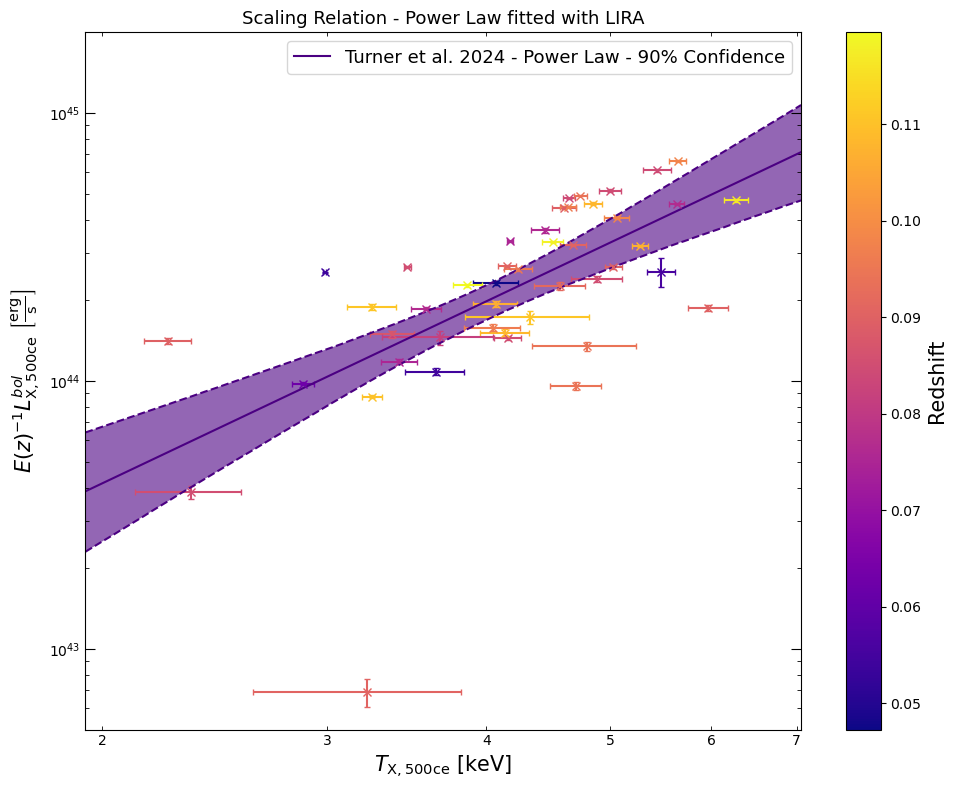

In [24]:
lxbol_tx_r500ce_metfree.view(save_path=fig_pth+"lxbol_tx_r500ce_metfree.pdf", y_lims=Quantity([5e+42, 2e+45], 'erg/s'))

## Comparing the measured L-T relations

We now present comparisons between the different scaling relations we have measured. The XGA ScalingRelation instances can be combined using the add (+) Python operator - the resulting objects will then plot the data and corner plots on the same axes.

### $L^{52}_{\rm{X}}$-$T_{\rm{X}}$

We separate the different luminosity energy bands, starting with 0.5-2.0keV relations:

In [25]:
combo52 = (lx52_tx_r500_metfix + lx52_tx_r500_metfree + lx52_tx_r500ce_metfix + lx52_tx_r500ce_metfree)

/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/products/relation.py:1243: UserWarning: Not all of these ScalingRelations have the same x-axis names.
  warn('Not all of these ScalingRelations have the same x-axis names.')
/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/products/relation.py:1250: UserWarning: Not all of these ScalingRelations have the same y-axis names.
  warn('Not all of these ScalingRelations have the same y-axis names.')


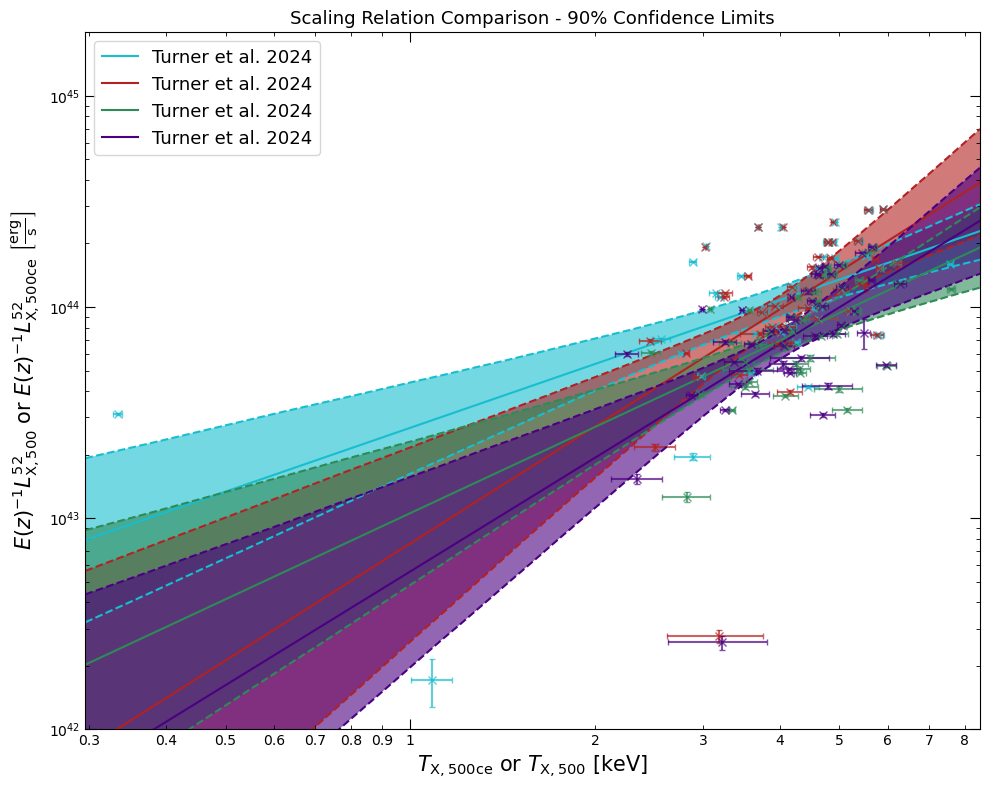

In [26]:
combo52.view(show_data=True, y_lims=Quantity([1e+42, 2e+45], 'erg/s'))

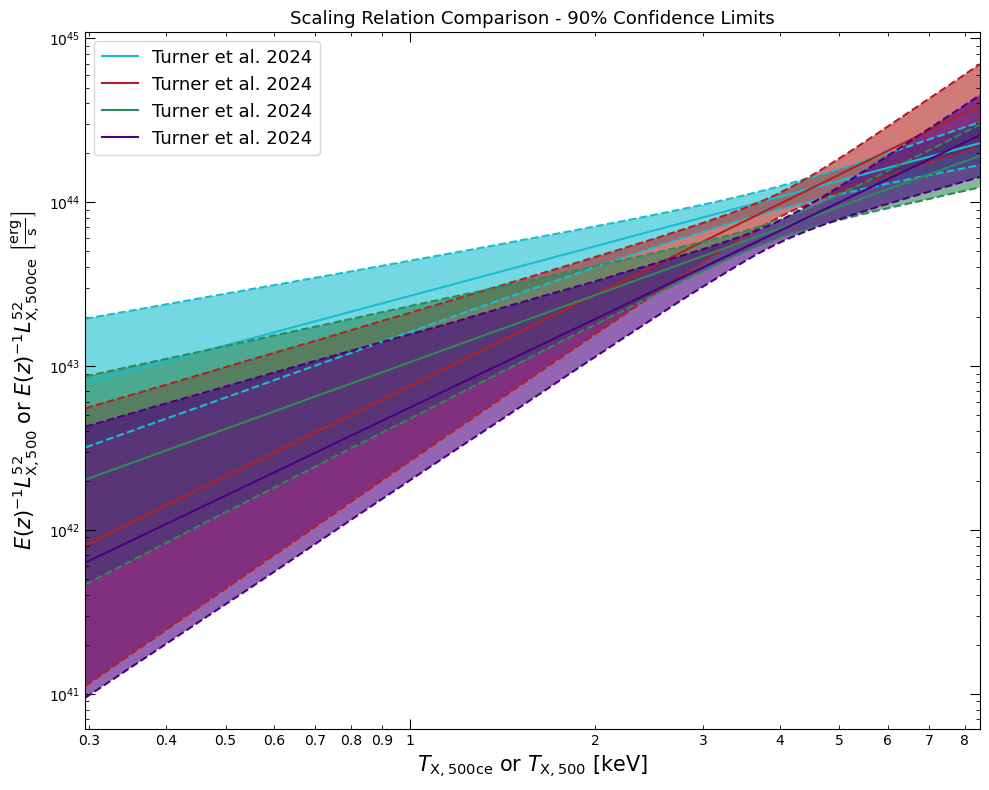

In [27]:
combo52.view(show_data=False)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


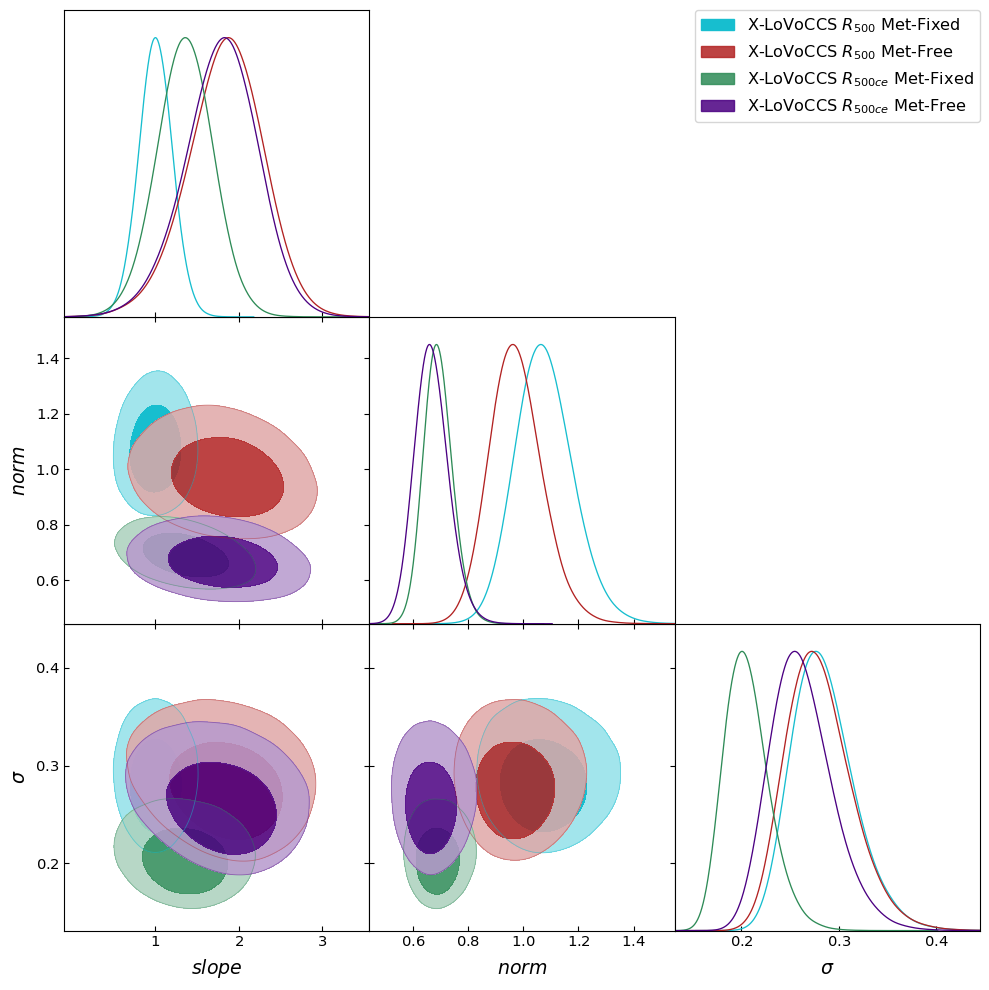

In [28]:
combo52.view_corner()

### $L^{bol}_{\rm{X}}$-$T_{\rm{X}}$

Then we show the bolometric luminosity relations:

In [29]:
combobol = (lxbol_tx_r500_metfix + lxbol_tx_r500_metfree + lxbol_tx_r500ce_metfix + lxbol_tx_r500ce_metfree)

/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/products/relation.py:1243: UserWarning: Not all of these ScalingRelations have the same x-axis names.
  warn('Not all of these ScalingRelations have the same x-axis names.')
/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/products/relation.py:1250: UserWarning: Not all of these ScalingRelations have the same y-axis names.
  warn('Not all of these ScalingRelations have the same y-axis names.')


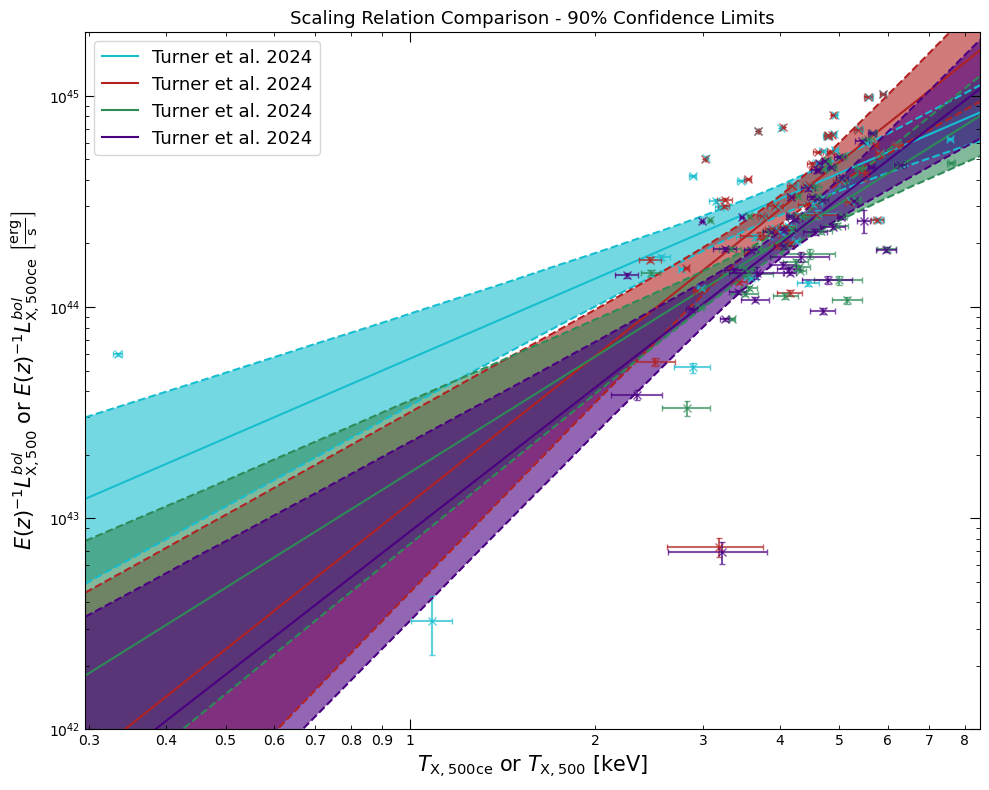

In [30]:
combobol.view(y_lims=Quantity([1e+42, 2e+45], 'erg/s'))

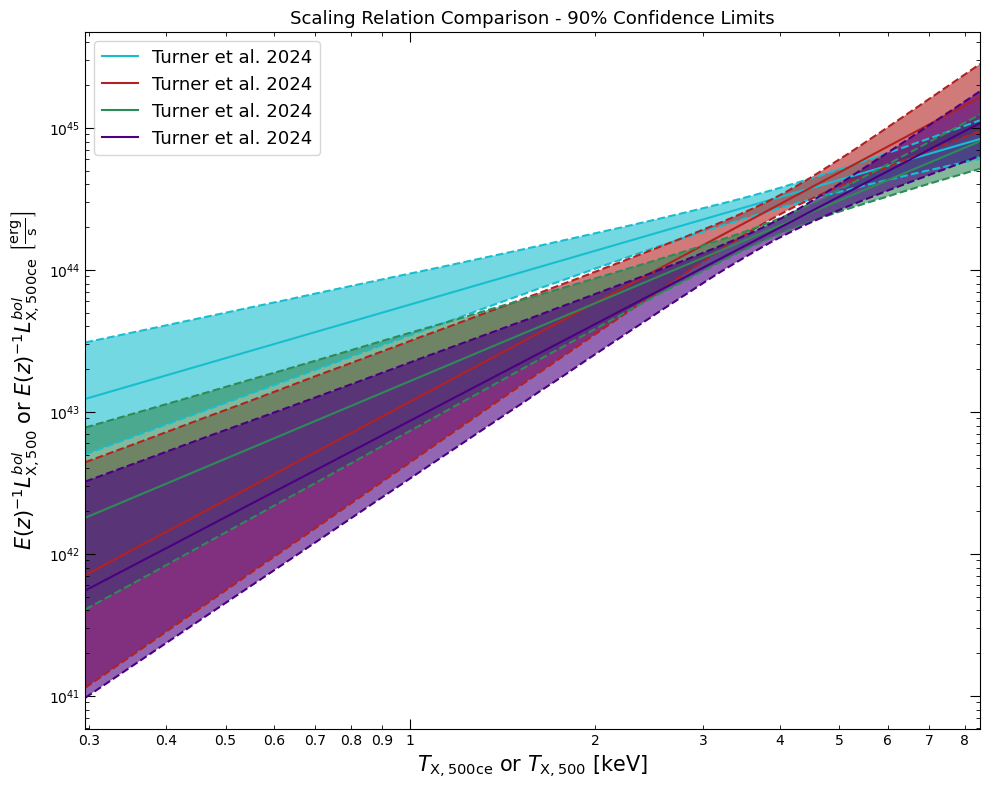

In [31]:
combobol.view(show_data=False)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


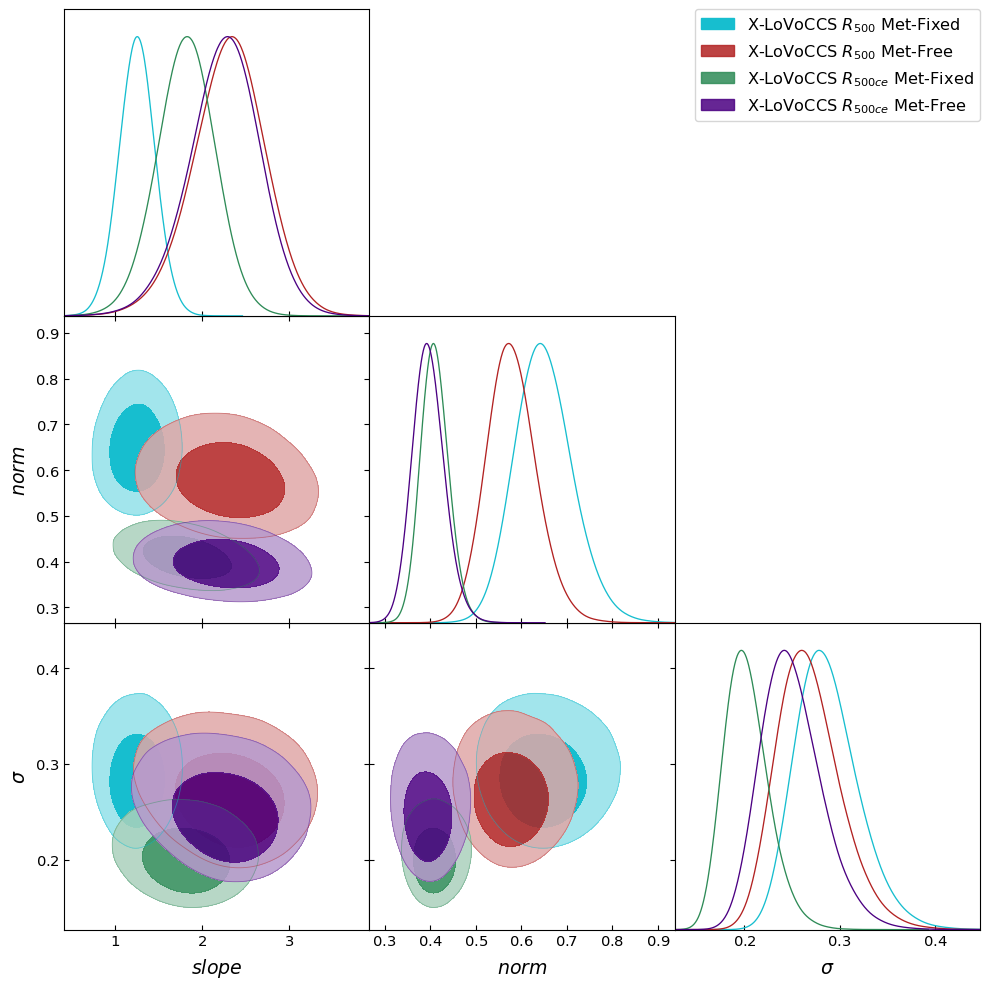

In [32]:
combobol.view_corner()

## Comparisons to literature

Here we make comparisons of our measurements to existing scaling relations taken from literature.

### SDSSRM-XCS

These scaling relations were measured from an optically selected (redMaPPer SDSS) cluster catalogue with archival XMM data - the SDSSRM clusters used for these final relations had very well constrained temperature measurements.

#### LoVoCCS $R_{500}$ Metallicity Free

/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/products/relation.py:1243: UserWarning: Not all of these ScalingRelations have the same x-axis names.
  warn('Not all of these ScalingRelations have the same x-axis names.')
/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/products/relation.py:1250: UserWarning: Not all of these ScalingRelations have the same y-axis names.
  warn('Not all of these ScalingRelations have the same y-axis names.')


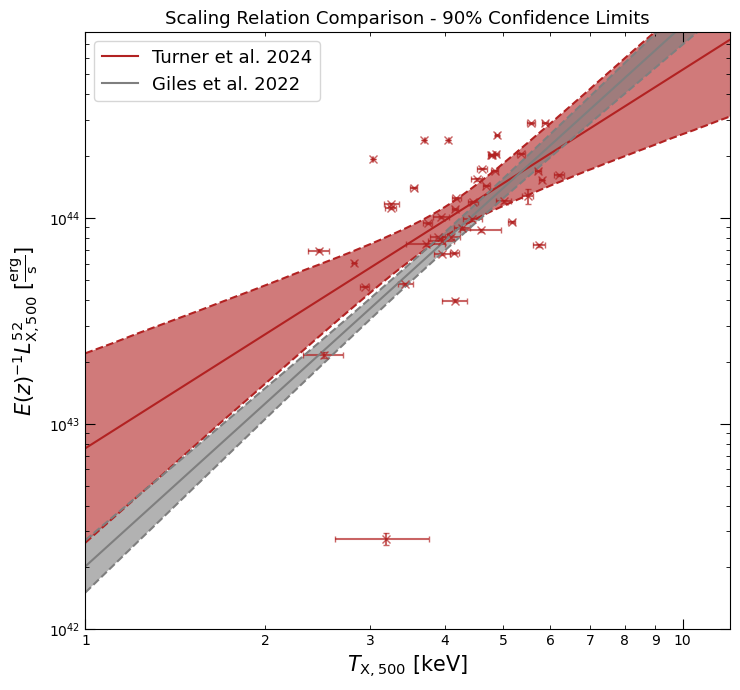

In [33]:
x_lab = lx52_tx_r500_metfree.x_name + " [keV]"
y_lab = lx52_tx_r500_metfree.y_name + r" [$\frac{\rm{erg}}{\rm{s}}$]"
(lx52_tx_r500_metfree + xcs_sdss_r500_52).view(figsize=(7.5, 7), custom_x_label=x_lab, custom_y_label=y_lab, 
                                               save_path=fig_pth+"lx52_tx_r500_metfree+sdssrm.pdf", 
                                               y_lims=Quantity([1e+42, 8e+44], 'erg/s'))

#### LoVoCCS $R_{500ce}$  Metallicity Free

/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/products/relation.py:1243: UserWarning: Not all of these ScalingRelations have the same x-axis names.
  warn('Not all of these ScalingRelations have the same x-axis names.')
/mnt/ufs18/home-218/turne540/code/main_branch_xga/XGA/xga/products/relation.py:1250: UserWarning: Not all of these ScalingRelations have the same y-axis names.
  warn('Not all of these ScalingRelations have the same y-axis names.')


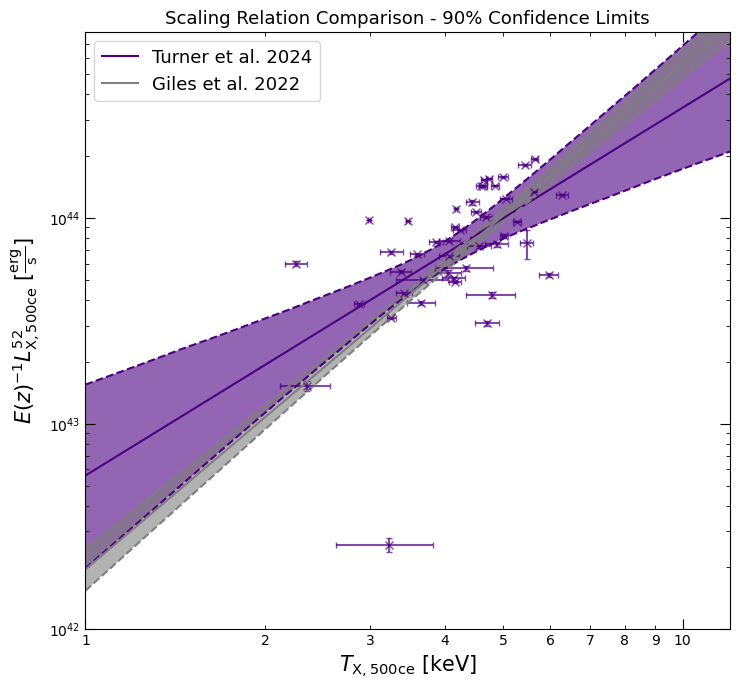

In [34]:
x_lab = lx52_tx_r500ce_metfree.x_name + " [keV]"
y_lab = lx52_tx_r500ce_metfree.y_name + r" [$\frac{\rm{erg}}{\rm{s}}$]"
(lx52_tx_r500ce_metfree + xcs_sdss_r500ce_52).view(figsize=(7.5, 7), custom_x_label=x_lab, custom_y_label=y_lab, 
                                                 save_path=fig_pth+"lx52_tx_r500ce_metfree+sdssrm.pdf", 
                                                   y_lims=Quantity([1e+42, 8e+44], 'erg/s'))